# Task 1: Evaluation of Base Model without Attack


In [1]:
import os
import zipfile
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import json
from torch.utils.data import DataLoader
from PIL import Image
import torchvision
from urllib.request import urlopen

## Properly Verify Dataset Path and Load into Runtime

In [2]:
zip_path = "./TestDataSet.zip"
extract_path = "./"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(extract_path)
  print("Extraction complete.")

if os.path.exists("./TestDataSet/TestDataSet"):
  dataset_path = "./TestDataSet/TestDataSet"
else:
  dataset_path = "./TestDataSet"

json_path = None
for root, dirs, files in os.walk("./"):
    for file in files:
        if file.endswith(".json"):
            json_path = os.path.join(root, file)
            print(f"Found JSON file: {json_path}")
            break
    if json_path:
        break

# ensure json file found
if not json_path:
    print("No JSON file found. Please check the extraction.")
    # Default to a common name just in case
    json_path = "./labels_list.json"

with open(json_path, 'r') as f:
    class_list = json.load(f)

class_mapping = {}
for class_entry in class_list:
    # Extract index and class name using regex
    match = re.match(r"(\d+): (.+)", class_entry)
    if match:
        idx, name = match.groups()
        class_mapping[name] = int(idx)

print(f"Checking if dataset path exists: {dataset_path}")
if not os.path.exists(dataset_path):
    # Try to find the folder with image subfolders
    potential_paths = []
    for root, dirs, files in os.walk("./TestDataSet"):
        if any(os.path.isdir(os.path.join(root, d)) for d in dirs):
            potential_paths.append(root)

    if potential_paths:
        dataset_path = potential_paths[0]
        print(f"Found potential dataset path: {dataset_path}")
    else:
        print("Could not find dataset path!")

print(f"Using dataset path: {dataset_path}")


Extraction complete.
Found JSON file: ./.config/.last_update_check.json
Checking if dataset path exists: ./TestDataSet
Using dataset path: ./TestDataSet


## Loading a pre-trained ResNet model

Let's load a ResNet34 model from `torchvision` and examine it.

In [3]:
# load pretrained model
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 183MB/s]


## Load and Preprocess Image Data

In [4]:
mean_norms = np.array([0.485, 0.456, 0.406], dtype=np.float32)
std_norms = np.array([0.229, 0.224, 0.225], dtype=np.float32)
plain_transforms = transforms.Compose([
transforms.ToTensor(),
transforms.Normalize(mean=mean_norms,
std=std_norms)
])

# load dataset
try:
    dataset = datasets.ImageFolder(root=dataset_path, transform=plain_transforms)
    print(f"Successfully loaded dataset with {len(dataset)} images")
    # Print some of the classes
    print(f"First 5 classes: {dataset.classes[:5]}")
except Exception as e:
    print(f"Error loading dataset: {e}")

# dataloader
batch_size = 32
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)


json_path = "./TestDataSet/labels_list.json"

# load the JSON file
with open(json_path, 'r') as f:
    class_list = json.load(f)
    print(f"Successfully loaded class_list: {type(class_list)}")
    if isinstance(class_list, list) and len(class_list) > 0:
        print(f"First class entry: {class_list[0]}")

# mapping from dataset indices to ImageNet indices
idx_to_imagenet = {}
for idx, class_name in enumerate(dataset.classes):
    if idx < len(class_list):
        entry = class_list[idx]
        match = re.match(r"(\d+): (.+)", entry)
        if match:
            imagenet_idx = int(match.groups()[0])
            idx_to_imagenet[idx] = imagenet_idx
            if idx < 5:
                print(f"Mapped {class_name} to ImageNet index {imagenet_idx}")
    else:
        print(f"Warning: Class '{class_name}' has no corresponding entry in the JSON file.")

Successfully loaded dataset with 500 images
First 5 classes: ['n02672831', 'n02676566', 'n02687172', 'n02690373', 'n02692877']
Successfully loaded class_list: <class 'list'>
First class entry: 401: accordion
Mapped n02672831 to ImageNet index 401
Mapped n02676566 to ImageNet index 402
Mapped n02687172 to ImageNet index 403
Mapped n02690373 to ImageNet index 404
Mapped n02692877 to ImageNet index 405


## Evaluation of Model on Base Dataset

In [5]:
pretrained_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_model.to(device)
correct_top1 = 0
correct_top5 = 0
total = 0

with torch.no_grad():
  for images, labels in data_loader:
    images, labels = images.to(device), labels.to(device)

    # forward
    outputs = pretrained_model(images)

    # top 1 and top 5 preds
    _, preds_top1 = torch.max(outputs, 1)
    _, preds_top5 = torch.topk(outputs, 5, dim=1)

    for i, label in enumerate(labels):
      dataset_idx = label.item()
      if dataset_idx in idx_to_imagenet:
        imagenet_idx = idx_to_imagenet[dataset_idx]
        total+=1

        if preds_top1[i].item() == imagenet_idx:
          correct_top1 += 1
        if imagenet_idx in preds_top5[i].tolist():
          correct_top5 += 1

  top1_acc = 100 * correct_top1 / total
  top5_acc = 100 * correct_top5 / total

  print(f"Top-1 Accuracy: {top1_acc:.2f}%")
  print(f"Top-5 Accuracy: {top5_acc:.2f}%")

Top-1 Accuracy: 76.00%
Top-5 Accuracy: 94.20%


# Task 2: Pixel-wise Attacks

In [6]:
# create adversarial examples using FGSM
def create_adversarial_example(model, image, true_label, epsilon=0.02):
    image.requires_grad = True
    output = model(image.unsqueeze(0))
    loss = F.cross_entropy(output, torch.tensor([true_label]).to(device))

    # backward pass to get gradients
    model.zero_grad()
    loss.backward()

    # normalization constants
    mean = torch.tensor(mean_norms, device=device).view(3, 1, 1)
    std = torch.tensor(std_norms, device=device).view(3, 1, 1)

    # denormalize back to raw pixel space for applying noise
    image_raw = image * std + mean

    # raw space gradients from image
    grad_raw = image.grad / std


    # create perturbated image using the handout eqn x <- x + epsilon*sign of data grad
    adv_raw = image_raw + epsilon*grad_raw.sign()  # Fixed the variable name here
    adv_raw = torch.clamp(adv_raw, 0.0, 1.0)

    # renormalize for network
    adv_norm = (adv_raw - mean) / std

    return adv_norm.detach()

In [7]:
# directory to store the adversarial images
adv_dataset_path = "./AdversarialTestSet1"
os.makedirs(adv_dataset_path, exist_ok=True)

# class structure
for class_folder in os.listdir(dataset_path):
    if os.path.isdir(os.path.join(dataset_path, class_folder)):
        os.makedirs(os.path.join(adv_dataset_path, class_folder), exist_ok=True)

single_loader = DataLoader(dataset, batch_size=1, shuffle=False)

# keep track of L∞ distances
max_distances = []

print("Start generating adversarial examples")
for i, (image, label) in enumerate(single_loader):
  # limit to 500 images as instructed
  if i>=500:
    break
  if i% 50 == 0:
    print(f"Processing image {i}/500...")

  image_path = dataset.samples[i][0]
  class_folder = os.path.basename(os.path.dirname(image_path))
  image_name = os.path.basename(image_path)
  image, label = image.squeeze(0).to(device), label.to(device)

  dataset_idx = label.item()
  if dataset_idx not in idx_to_imagenet:
    print(f"Skipping image {i}, class {dataset_idx} not found in mapping")
    continue

  imagenet_idx = idx_to_imagenet[dataset_idx]

  # create adversarial example
  adv_image = create_adversarial_example(pretrained_model, image, imagenet_idx, epsilon=0.02)

  mean = torch.tensor(mean_norms, device=device).view(3,1,1)
  std  = torch.tensor(std_norms, device=device).view(3,1,1)

  # denormalize both original and adversarial
  orig_raw = image      * std + mean   # now in [0,1]
  adv_raw  = adv_image  * std + mean

  # compute L∞ distance between original and adversarial
  l_inf_raw = (adv_raw - orig_raw).abs().max().item()
  max_distances.append(l_inf_raw)

  adv_np = (adv_raw.cpu().numpy().transpose(1,2,0) * 255).round().astype(np.uint8)
  adv_pil = Image.fromarray(adv_np)

  # save
  adv_pil.save(os.path.join(adv_dataset_path, class_folder, image_name))


print("Finished generating adversarial examples.")
print(f"Maximum raw L∞ distance: {max(max_distances):.4f}")
print(f"Average raw L∞ distance: {sum(max_distances)/len(max_distances):.4f}")


Start generating adversarial examples
Processing image 0/500...
Processing image 50/500...
Processing image 100/500...
Processing image 150/500...
Processing image 200/500...
Processing image 250/500...
Processing image 300/500...
Processing image 350/500...
Processing image 400/500...
Processing image 450/500...
Finished generating adversarial examples.
Maximum raw L∞ distance: 0.0200
Average raw L∞ distance: 0.0200


## Evaluate Model on Adversarial Dataset

In [8]:
pretrained_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_model.to(device)
adv_dataset = datasets.ImageFolder(root=adv_dataset_path, transform=plain_transforms)
adv_loader = DataLoader(adv_dataset, batch_size=32, shuffle=False)

adv_correct_top1 = 0
adv_correct_top5 = 0
adv_total = 0

print("Evaluating model on adversarial examples...")
with torch.no_grad():
    for images, labels in adv_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = pretrained_model(images)

        _, pred_top1 = torch.max(outputs, 1)
        _, pred_top5 = torch.topk(outputs, 5, dim=1)

        for i, label in enumerate(labels):
            dataset_idx = label.item()
            if dataset_idx in idx_to_imagenet:
                imagenet_idx = idx_to_imagenet[dataset_idx]
                adv_total += 1

                if pred_top1[i].item() == imagenet_idx:
                    adv_correct_top1 += 1

                if imagenet_idx in pred_top5[i].tolist():
                    adv_correct_top5 += 1

adv_top1_acc = 100 * adv_correct_top1 / adv_total
adv_top5_acc = 100 * adv_correct_top5 / adv_total

print(f"Adversarial Top-1 Accuracy: {adv_top1_acc:.2f}%")
print(f"Adversarial Top-5 Accuracy: {adv_top5_acc:.2f}%")

# relative accuracy drop
top1_drop_relative = (top1_acc - adv_top1_acc) / top1_acc * 100
top5_drop_relative = (top5_acc - adv_top5_acc) / top5_acc * 100

print(f"Relative Top-1 Accuracy Drop: {top1_drop_relative:.2f}%")
print(f"Relative Top-5 Accuracy Drop: {top5_drop_relative:.2f}%")

if top1_drop_relative >= 50:
    print("Achieved >50% relative drop in top-1 accuracy.")
else:
    print(f"Recommended target not met. Need to increase attack strength to achieve >50% drop.")


Evaluating model on adversarial examples...
Adversarial Top-1 Accuracy: 6.20%
Adversarial Top-5 Accuracy: 33.20%
Relative Top-1 Accuracy Drop: 91.84%
Relative Top-5 Accuracy Drop: 64.76%
Achieved >50% relative drop in top-1 accuracy.


## Visualization of 3-5 Cases of Model Failures

Loaded 1000 ImageNet classes
Example classes: tench, black swan, cliff dwelling


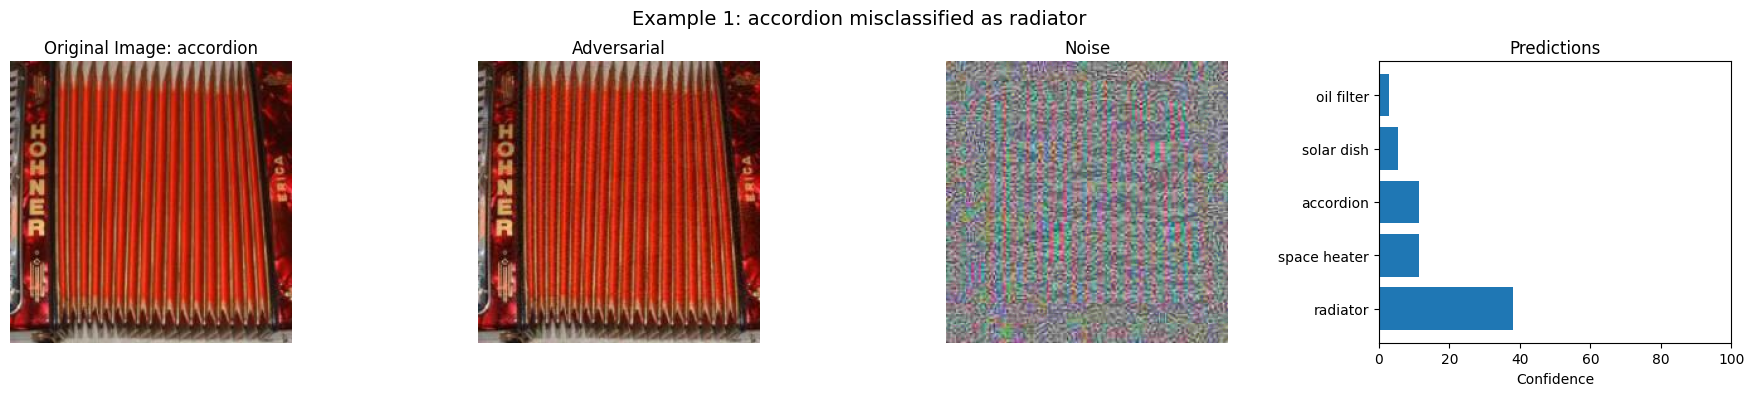

Original class: accordion (ImageNet index: 401)
Misclassified as: radiator (ImageNet index: 753)
Top 5 predictions for adversarial image:
  1. radiator: 37.98%
  2. space heater: 11.44%
  3. accordion: 11.30%
  4. solar dish: 5.41%
  5. oil filter: 2.97%




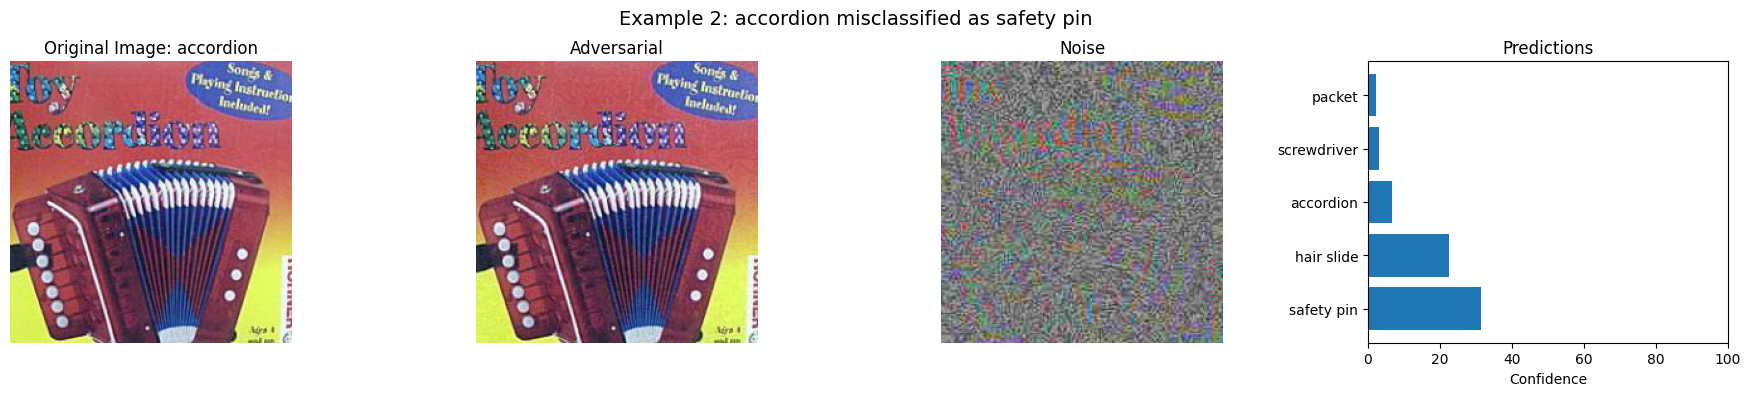

Original class: accordion (ImageNet index: 401)
Misclassified as: safety pin (ImageNet index: 772)
Top 5 predictions for adversarial image:
  1. safety pin: 31.40%
  2. hair slide: 22.62%
  3. accordion: 6.70%
  4. screwdriver: 3.03%
  5. packet: 2.37%




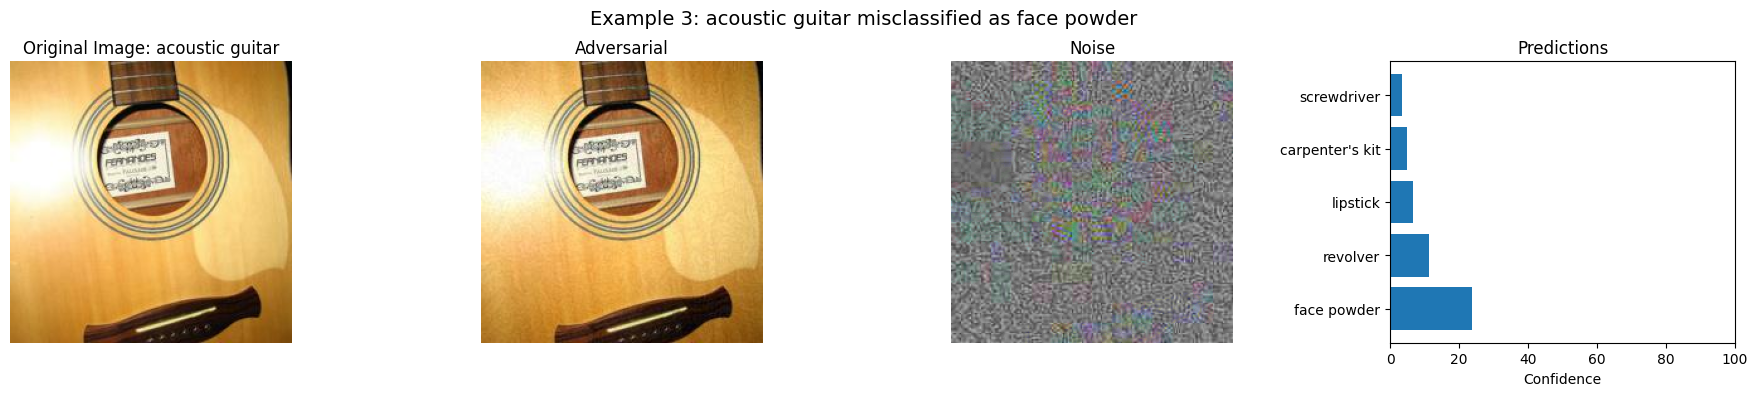

Original class: acoustic guitar (ImageNet index: 402)
Misclassified as: face powder (ImageNet index: 551)
Top 5 predictions for adversarial image:
  1. face powder: 23.73%
  2. revolver: 11.18%
  3. lipstick: 6.69%
  4. carpenter's kit: 4.93%
  5. screwdriver: 3.59%




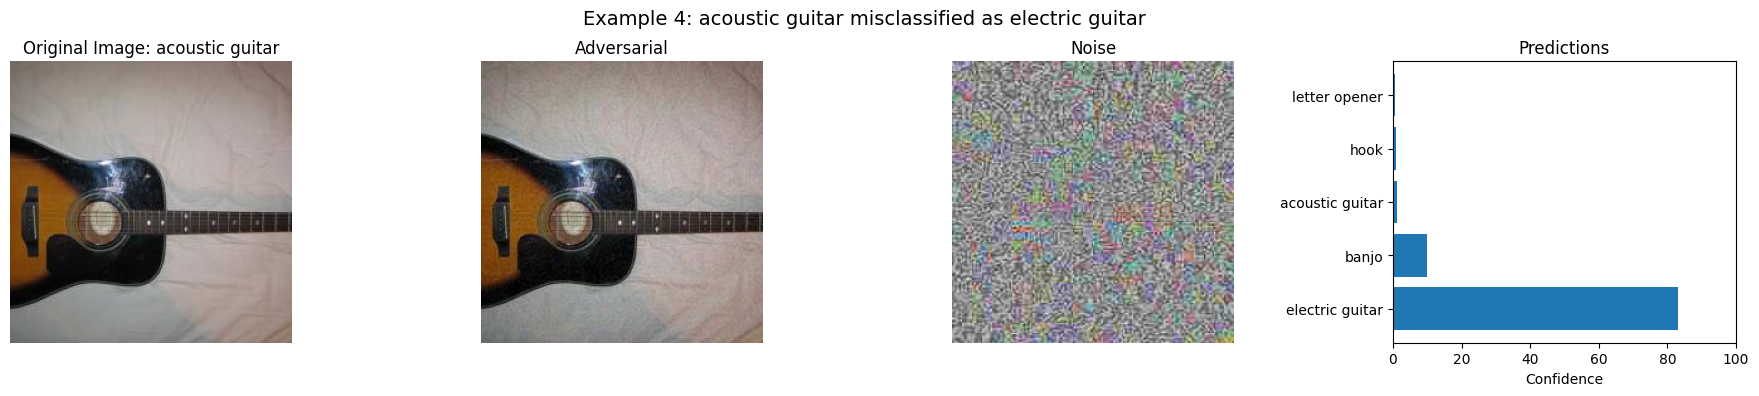

Original class: acoustic guitar (ImageNet index: 402)
Misclassified as: electric guitar (ImageNet index: 546)
Top 5 predictions for adversarial image:
  1. electric guitar: 82.94%
  2. banjo: 10.05%
  3. acoustic guitar: 1.28%
  4. hook: 0.75%
  5. letter opener: 0.64%




In [9]:
# complete ImageNet class mapping
from urllib.request import urlopen

# Get the complete ImageNet class mapping from PyTorch's repository
url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
with urlopen(url) as response:
    classes = [line.decode('utf-8').strip() for line in response.readlines()]

# Create a mapping from class index to class name
imagenet_class_mapping = {}
for i, classname in enumerate(classes):
    imagenet_class_mapping[i] = classname

print(f"Loaded {len(imagenet_class_mapping)} ImageNet classes")
print(f"Example classes: {imagenet_class_mapping[0]}, {imagenet_class_mapping[100]}, {imagenet_class_mapping[500]}")

# Now update the visualization function with this mapping
def visualize_adversarial_examples(model, dataset, adv_dataset, idx_to_imagenet, imagenet_mapping, n_examples=5):
    model.eval()

    inv_normalize = transforms.Compose([
        transforms.Normalize(
            mean=[-m/s for m, s in zip(mean_norms, std_norms)],
            std=[1/s for s in std_norms]
        )
    ])

    successful_attacks = []

    with torch.no_grad():
        for i in range(min(500, len(dataset))):
            orig_img, label = dataset[i]
            orig_img = orig_img.to(device)

            adv_img, _ = adv_dataset[i]
            adv_img = adv_img.to(device)

            if label not in idx_to_imagenet:
                continue
            true_label = idx_to_imagenet[label]

            orig_output = model(orig_img.unsqueeze(0))
            adv_output = model(adv_img.unsqueeze(0))

            _, orig_pred = torch.max(orig_output, 1)
            _, adv_pred = torch.max(adv_output, 1)

            if orig_pred.item() == true_label and adv_pred.item() != true_label:
                _, adv_top5 = torch.topk(adv_output, 5, dim=1)
                adv_top5 = adv_top5.squeeze().cpu().numpy()

                confidences = torch.nn.functional.softmax(adv_output, dim=1).squeeze().cpu().numpy()
                top5_confidences = confidences[adv_top5]

                # Use the complete ImageNet mapping
                true_name = imagenet_mapping.get(true_label, f"Class {true_label}")
                adv_name = imagenet_mapping.get(adv_pred.item(), f"Class {adv_pred.item()}")
                top5_names = [imagenet_mapping.get(idx, f"Class {idx}") for idx in adv_top5]

                successful_attacks.append({
                    'index': i,
                    'orig_img': inv_normalize(orig_img).cpu(),
                    'adv_img': inv_normalize(adv_img).cpu(),
                    'noise': (adv_img - orig_img).cpu(),
                    'true_label': true_label,
                    'true_name': true_name,
                    'adv_pred': adv_pred.item(),
                    'adv_name': adv_name,
                    'adv_top5': adv_top5,
                    'top5_names': top5_names,
                    'top5_confidences': top5_confidences
                })

                if len(successful_attacks) >= n_examples:
                    break

    if not successful_attacks:
        print("No successful attacks found to visualize.")
        return

    n_examples = min(n_examples, len(successful_attacks))

    for i, attack in enumerate(successful_attacks[:n_examples]):
        fig, axs = plt.subplots(1, 4, figsize=(18, 4))

        axs[0].imshow(attack['orig_img'].permute(1, 2, 0).numpy())
        axs[0].set_title(f"Original Image: {attack['true_name']}")
        axs[0].axis('off')

        axs[1].imshow(attack['adv_img'].permute(1, 2, 0).numpy())
        axs[1].set_title("Adversarial")
        axs[1].axis('off')

        noise = attack['noise'].permute(1, 2, 0).numpy()
        # Make noise more visible with random-like appearance
        scaled_noise = np.clip((noise - noise.min()) / (noise.max() - noise.min()), 0, 1)
        axs[2].imshow(scaled_noise)
        axs[2].set_title("Noise")
        axs[2].axis('off')

        y_pos = np.arange(len(attack['top5_names']))
        axs[3].barh(y_pos, attack['top5_confidences'] * 100)
        axs[3].set_yticks(y_pos)
        axs[3].set_yticklabels(attack['top5_names'])
        axs[3].set_title("Predictions")
        axs[3].set_xlabel("Confidence")
        axs[3].set_xlim(0, 100)

        plt.tight_layout()
        plt.suptitle(f"Example {i+1}: {attack['true_name']} misclassified as {attack['adv_name']}", fontsize=14)
        plt.subplots_adjust(top=0.85)
        plt.show()

        print(f"Original class: {attack['true_name']} (ImageNet index: {attack['true_label']})")
        print(f"Misclassified as: {attack['adv_name']} (ImageNet index: {attack['adv_pred']})")
        print(f"Top 5 predictions for adversarial image:")
        for j, (name, conf) in enumerate(zip(attack['top5_names'], attack['top5_confidences'])):
            print(f"  {j+1}. {name}: {conf*100:.2f}%")
        print("\n")

# Visualize with the complete mapping
visualize_adversarial_examples(pretrained_model, dataset, adv_dataset, idx_to_imagenet, imagenet_class_mapping, n_examples=4)

# Task 3: Enhanced Attack using PGD


In [10]:
epsilon = 0.02
num_steps=40
alpha = epsilon/num_steps
def create_adversarial_example_pgd(model, image, true_label,
                                   epsilon=epsilon, alpha=alpha, num_steps=num_steps):
    model.eval()
    device = image.device

    mean = torch.tensor(mean_norms, device=device).view(3,1,1)
    std  = torch.tensor(std_norms, device=device).view(3,1,1)

    # denormalize once
    orig_raw = image * std + mean
    adv_raw  = orig_raw.clone().detach().requires_grad_(True)

    for _ in range(num_steps):
        # re‐normalize for model input
        adv_norm = (adv_raw - mean) / std
        output   = model(adv_norm.unsqueeze(0))
        loss     = F.cross_entropy(output, torch.tensor([true_label], device=device))

        model.zero_grad()
        loss.backward()

        # gradient in raw space
        grad_raw = adv_raw.grad.data

        # one FGSM step
        adv_raw = adv_raw + alpha * grad_raw.sign()

        # project back into the L∞ ball around orig_raw, then clamp to [0,1]
        adv_raw = torch.max(torch.min(adv_raw, orig_raw + epsilon), orig_raw - epsilon)
        adv_raw = torch.clamp(adv_raw, 0.0, 1.0)

        # re‐attach grad
        adv_raw = adv_raw.detach().requires_grad_(True)

    # final normalized adversarial
    adv_norm = (adv_raw - mean) / std
    return adv_norm.detach()


In [11]:
# generate images with PGD attack

from torch.utils.data import DataLoader
from PIL import Image
import os, numpy as np

adv2_path = "./AdversarialTestSet2"
os.makedirs(adv2_path, exist_ok=True)
for cls in os.listdir(dataset_path):
    if os.path.isdir(os.path.join(dataset_path, cls)):
        os.makedirs(os.path.join(adv2_path, cls), exist_ok=True)

single_loader = DataLoader(dataset, batch_size=1, shuffle=False)
max_dist2 = []

print("Start PGD adversarial generation (500 imgs)...")
for i, (img, lbl) in enumerate(single_loader):
    if i >= 500: break
    img, lbl = img.squeeze(0).to(device), lbl.to(device)
    ds_idx   = lbl.item()
    if ds_idx not in idx_to_imagenet:
        continue
    im_idx = idx_to_imagenet[ds_idx]

    adv2 = create_adversarial_example_pgd(pretrained_model, img, im_idx,
                                          epsilon=0.02, alpha=0.005, num_steps=10)

    # measure raw L∞
    mean = torch.tensor(mean_norms, device=device).view(3,1,1)
    std  = torch.tensor(std_norms, device=device).view(3,1,1)
    raw_o = img * std + mean
    raw_a = torch.clamp(adv2 * std + mean, 0.0, 1.0)
    l_inf = (raw_a - raw_o).abs().max().item()
    max_dist2.append(l_inf)

    # save adv image as uint8 PNG
    arr = (raw_a.cpu().numpy().transpose(1,2,0)*255).round().astype(np.uint8)
    pil = Image.fromarray(arr)
    path = dataset.samples[i][0]
    folder = os.path.basename(os.path.dirname(path))
    name   = os.path.basename(path)
    pil.save(os.path.join(adv2_path, folder, name))

print("Done.")
print(f"Max L∞ raw: {max(max_dist2):.4f}, Avg raw: {sum(max_dist2)/len(max_dist2):.4f}")


Start PGD adversarial generation (500 imgs)...
Done.
Max L∞ raw: 0.0200, Avg raw: 0.0200


In [12]:
# evaluate model on pgd dataset

adv2_dataset = datasets.ImageFolder(root=adv2_path, transform=plain_transforms)
adv2_loader  = DataLoader(adv2_dataset, batch_size=32, shuffle=False)

adv2_top1, adv2_top5, tot2 = 0, 0, 0
print("Evaluating on Test Set 2...")
with torch.no_grad():
    for imgs, lbls in adv2_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        outs = pretrained_model(imgs)

        # top-1
        _, p1 = outs.topk(1, dim=1)
        # top-5
        _, p5 = outs.topk(5, dim=1)

        for j, lab in enumerate(lbls):
            ds_idx = lab.item()
            if ds_idx not in idx_to_imagenet:
                continue
            im_idx = idx_to_imagenet[ds_idx]
            tot2 += 1
            if p1[j,0].item() == im_idx:
                adv2_top1 += 1
            if im_idx in p5[j].tolist():
                adv2_top5 += 1

adv2_top1_acc = 100 * adv2_top1 / tot2
adv2_top5_acc = 100 * adv2_top5 / tot2
pgd_drop_1 = 100 * (top1_acc - adv2_top1_acc) / top1_acc
pgd_drop_5 = 100 * (top5_acc - adv2_top5_acc) / top5_acc
print(f"PGD Adversarial Top-1 Accuracy: {adv2_top1_acc:.2f}")
print(f"PGD Adversarial Top-5 Accuracy: {adv2_top5_acc:.2f}")
print(f"Drop in Top-1: {pgd_drop_1:.2f}%, Drop in Top-5: {pgd_drop_5:.2f}%")

Evaluating on Test Set 2...
PGD Adversarial Top-1 Accuracy: 1.20
PGD Adversarial Top-5 Accuracy: 30.80
Drop in Top-1: 98.42%, Drop in Top-5: 67.30%


## Improvement Attempt: Momentum Iterative Method (MIM)

In [13]:
# MIM (momentum PGD) under the same ε=0.02 constraint

def create_adversarial_example_mim(model, image, true_label,
                                   epsilon=0.02, alpha=0.0005, num_steps=40, decay=1.0):
    device = image.device
    model.eval()

    # build mean/std
    mean = torch.tensor(mean_norms, device=device).view(3,1,1)
    std  = torch.tensor(std_norms, device=device).view(3,1,1)

    # denormalize to raw [0,1]
    orig_raw = image * std + mean
    adv_raw  = orig_raw.clone().detach().requires_grad_(True)
    momentum = torch.zeros_like(orig_raw)

    for _ in range(num_steps):
        # normalize for the network
        adv_norm = (adv_raw - mean) / std
        out      = model(adv_norm.unsqueeze(0))
        loss     = F.cross_entropy(out, torch.tensor([true_label], device=device))

        model.zero_grad()
        loss.backward()

        # get gradient in raw space
        grad = adv_raw.grad.data
        # normalize its magnitude per-example
        grad_norm = grad / torch.mean(torch.abs(grad), dim=(1,2), keepdim=True)

        # update momentum and take a step
        momentum = decay * momentum + grad_norm
        adv_raw   = adv_raw + alpha * momentum.sign()

        # project back into the L∞ ball and clamp
        adv_raw = torch.max(torch.min(adv_raw, orig_raw + epsilon),
                            orig_raw - epsilon)
        adv_raw = torch.clamp(adv_raw, 0.0, 1.0).detach().requires_grad_(True)

    # final normalize
    adv_norm = (adv_raw - mean) / std
    return adv_norm.detach()


In [14]:
# generate mim images

from torch.utils.data import DataLoader
from PIL import Image
import os, numpy as np

adv2i_path = "./AdversarialTestSet2_Improved"
os.makedirs(adv2i_path, exist_ok=True)
for cls in os.listdir(dataset_path):
    if os.path.isdir(os.path.join(dataset_path, cls)):
        os.makedirs(os.path.join(adv2i_path, cls), exist_ok=True)

single_loader = DataLoader(dataset, batch_size=1, shuffle=False)
max_dist3 = []

print("Start MIM adversarial generation (500 imgs)...")
for i, (img, lbl) in enumerate(single_loader):
    if i >= 500: break
    img, lbl = img.squeeze(0).to(device), lbl.to(device)
    ds_idx   = lbl.item()
    if ds_idx not in idx_to_imagenet:
        continue
    im_idx = idx_to_imagenet[ds_idx]

    adv2i = create_adversarial_example_mim(pretrained_model, img, im_idx,
                                          epsilon=0.02,
                                          alpha=0.02/40,
                                          num_steps=40,
                                          decay=1.0)

    # measure raw L∞
    mean = torch.tensor(mean_norms, device=device).view(3,1,1)
    std  = torch.tensor(std_norms, device=device).view(3,1,1)
    raw_o = img * std + mean
    raw_a = torch.clamp(adv2i * std + mean, 0.0, 1.0)
    l_inf = (raw_a - raw_o).abs().max().item()
    max_dist3.append(l_inf)

    # save uint8 PNG
    arr = (raw_a.cpu().numpy().transpose(1,2,0) * 255).round().astype(np.uint8)
    pil = Image.fromarray(arr)
    path = dataset.samples[i][0]
    folder = os.path.basename(os.path.dirname(path))
    name   = os.path.basename(path)
    pil.save(os.path.join(adv2i_path, folder, name))

print("Done generating Test Set 3.")
print(f"Max raw L∞: {max(max_dist3):.4f}, Avg raw L∞: {sum(max_dist3)/len(max_dist3):.4f}")


Start MIM adversarial generation (500 imgs)...
Done generating Test Set 3.
Max raw L∞: 0.0200, Avg raw L∞: 0.0200


In [15]:
# eval model on mim dataset

adv2i_dataset = datasets.ImageFolder(root=adv2i_path, transform=plain_transforms)
adv2i_loader  = DataLoader(adv2i_dataset, batch_size=32, shuffle=False)

adv2i_top1, adv2i_top5, tot2i = 0, 0, 0
print("Evaluating on Improved Test Set 2 (MIM)...")
with torch.no_grad():
    for imgs, lbls in adv2i_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        outs = pretrained_model(imgs)

        _, p1 = outs.topk(1, dim=1)
        _, p5 = outs.topk(5, dim=1)

        for j, lab in enumerate(lbls):
            ds_idx = lab.item()
            if ds_idx not in idx_to_imagenet:
                continue
            im_idx = idx_to_imagenet[ds_idx]
            tot2i += 1
            if p1[j,0].item() == im_idx:       adv2i_top1 += 1
            if im_idx in p5[j].tolist():      adv2i_top5 += 1

# acc3_1 = 100 * adv3_top1 / tot3
# acc3_5 = 100 * adv3_top5 / tot3
# print(f"MIM Adversarial → Top-1: {acc3_1:.2f}%, Top-5: {acc3_5:.2f}%")
# print(f"Drop in Top-1: {(top1_acc-acc3_1)/top1_acc*100:.2f}%,"
#       f" Top-5: {(top5_acc-acc3_5)/top5_acc*100:.2f}%")


adv2i_top1_acc = 100 * adv2i_top1 / tot2i
adv2i_top5_acc = 100 * adv2i_top5 / tot2i
mim_drop_1 = 100 * (top1_acc - adv2i_top1_acc) / top1_acc
mim_drop_5 = 100 * (top5_acc - adv2i_top5_acc) / top5_acc
print(f"MIM Adversarial Top-1 Accuracy: {adv2i_top1_acc:.2f}")
print(f"MIM Adversarial Top-5 Accuracy: {adv2i_top5_acc:.2f}")
print(f"MIM Drop in Top-1 Relative to Base Model: {mim_drop_1:.2f}%, Drop in Top-5 Relative to Base Model: {mim_drop_5:.2f}%")


Evaluating on Improved Test Set 2 (MIM)...
MIM Adversarial Top-1 Accuracy: 0.00
MIM Adversarial Top-5 Accuracy: 11.80
MIM Drop in Top-1 Relative to Base Model: 100.00%, Drop in Top-5 Relative to Base Model: 87.47%


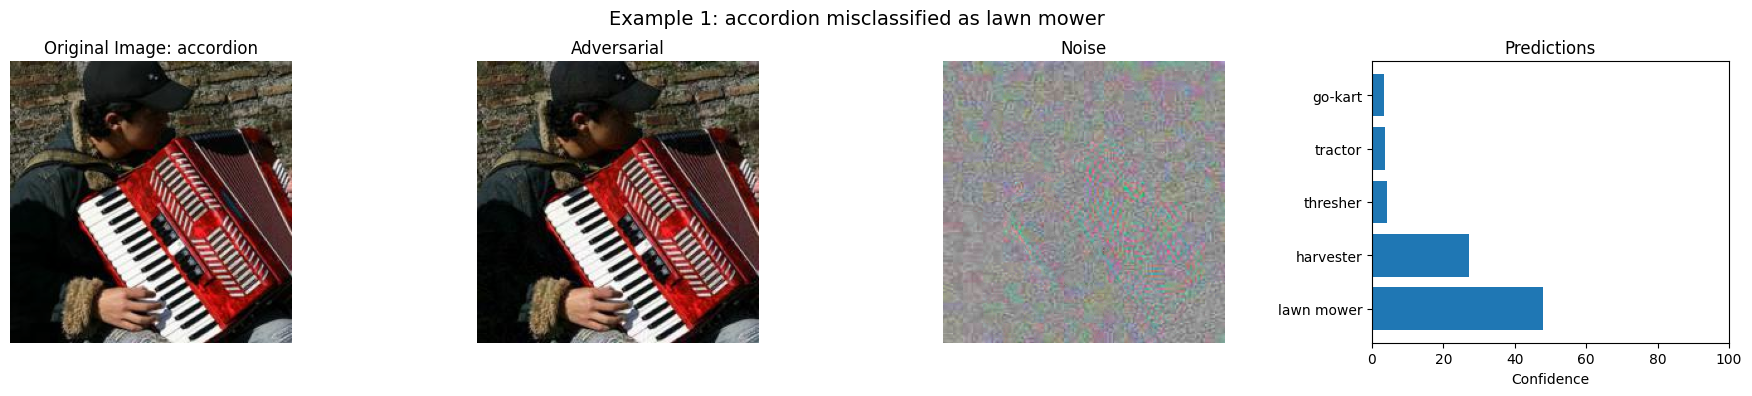

Original class: accordion (ImageNet index: 401)
Misclassified as: lawn mower (ImageNet index: 621)
Top 5 predictions for adversarial image:
  1. lawn mower: 47.81%
  2. harvester: 27.17%
  3. thresher: 4.30%
  4. tractor: 3.71%
  5. go-kart: 3.32%




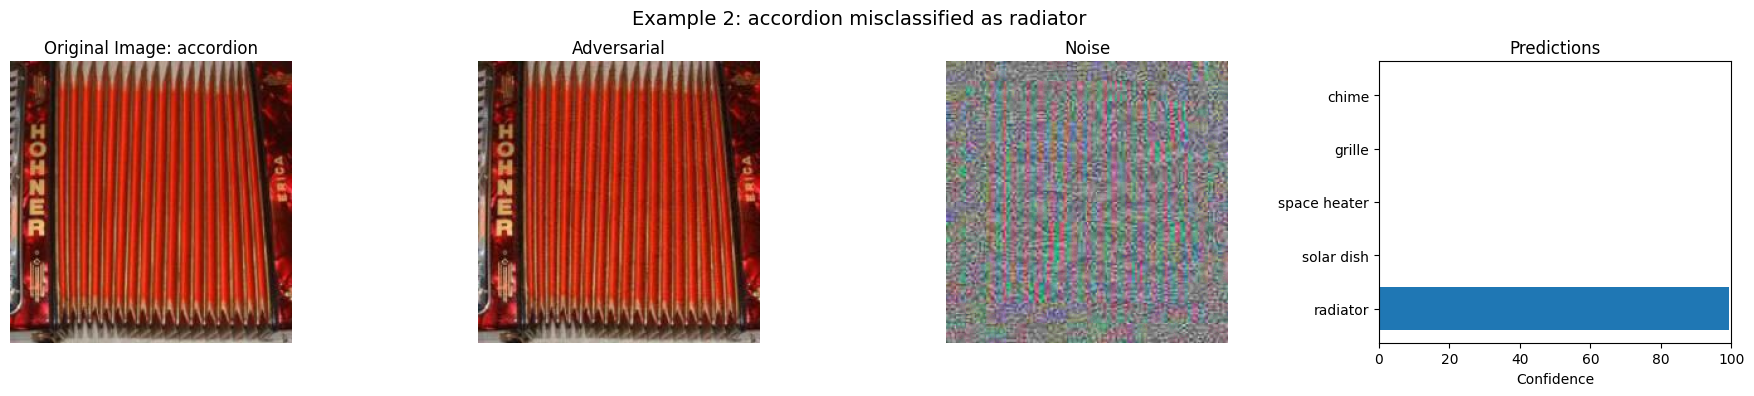

Original class: accordion (ImageNet index: 401)
Misclassified as: radiator (ImageNet index: 753)
Top 5 predictions for adversarial image:
  1. radiator: 99.25%
  2. solar dish: 0.45%
  3. space heater: 0.10%
  4. grille: 0.03%
  5. chime: 0.03%




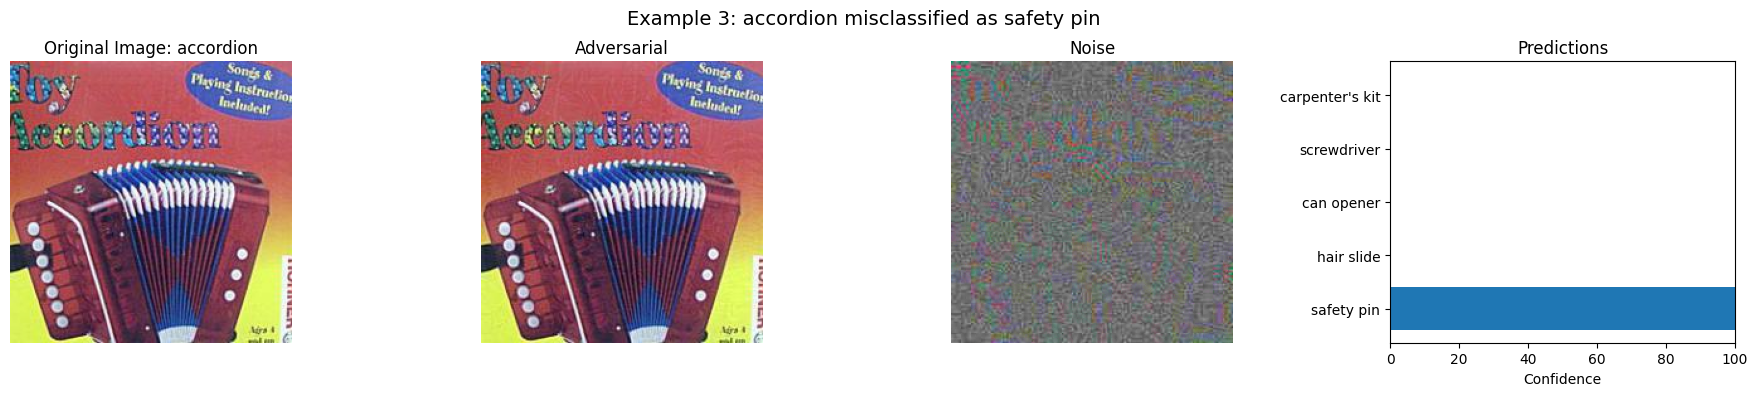

Original class: accordion (ImageNet index: 401)
Misclassified as: safety pin (ImageNet index: 772)
Top 5 predictions for adversarial image:
  1. safety pin: 99.96%
  2. hair slide: 0.03%
  3. can opener: 0.00%
  4. screwdriver: 0.00%
  5. carpenter's kit: 0.00%




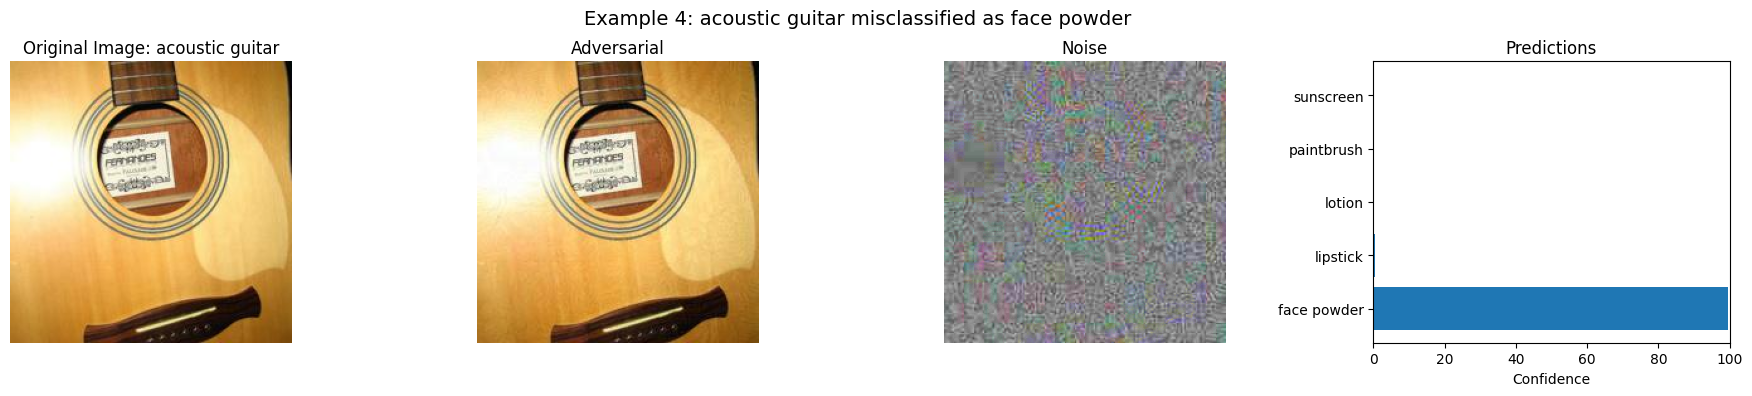

Original class: acoustic guitar (ImageNet index: 402)
Misclassified as: face powder (ImageNet index: 551)
Top 5 predictions for adversarial image:
  1. face powder: 99.46%
  2. lipstick: 0.51%
  3. lotion: 0.02%
  4. paintbrush: 0.00%
  5. sunscreen: 0.00%




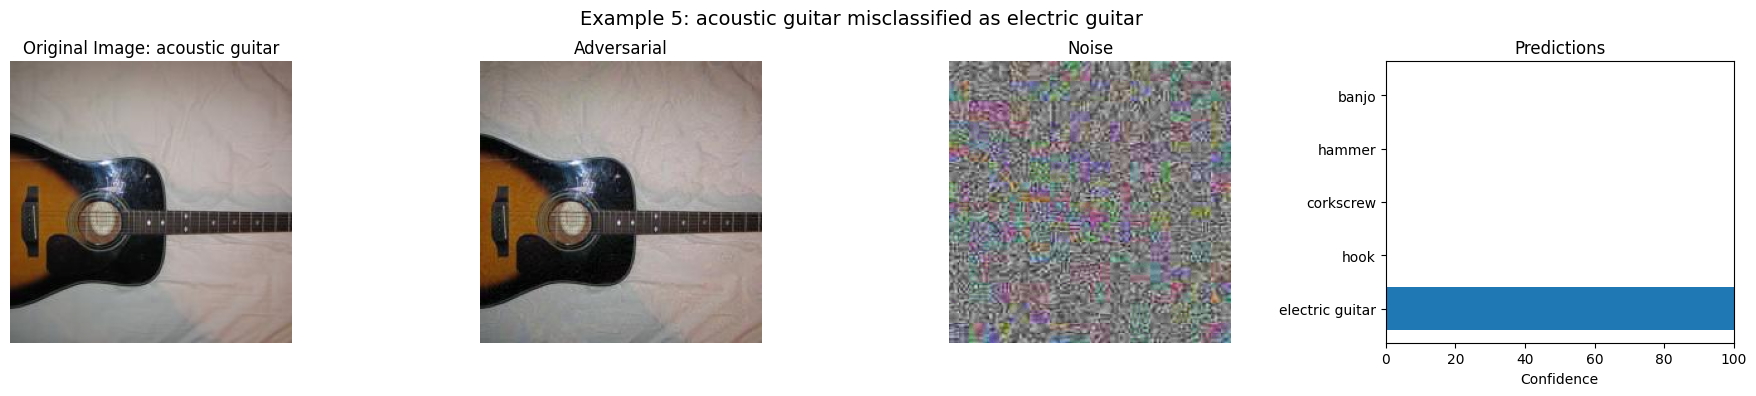

Original class: acoustic guitar (ImageNet index: 402)
Misclassified as: electric guitar (ImageNet index: 546)
Top 5 predictions for adversarial image:
  1. electric guitar: 99.98%
  2. hook: 0.01%
  3. corkscrew: 0.00%
  4. hammer: 0.00%
  5. banjo: 0.00%




In [16]:
visualize_adversarial_examples(pretrained_model,
                       dataset,
                       adv2i_dataset,
                       idx_to_imagenet,
                       imagenet_class_mapping,
                       n_examples=5)

# Task 4: Patch Attacks

Since MIM showed the most superior performance so far, we will stick to MIM to implement patch attacks

In [17]:
# targeted patch-MIM attack

def create_adversarial_example_patch_targeted_mim(
        model, image, true_label, target_label,
        epsilon=0.5,                # L∞ budget
        alpha=0.5/40,               # step size
        num_steps=40,               # iterations
        decay=1.0,                  # momentum
        patch_size=32):             # 32×32 patch
    """
    Only perturbs a random patch toward a chosen target_label by maximizing P[target].
    """
    device = image.device
    model.eval()

    # mean/std as before
    mean = torch.tensor(mean_norms, device=device).view(3,1,1)
    std  = torch.tensor(std_norms, device=device).view(3,1,1)

    # denormalize once
    orig_raw = image * std + mean
    adv_raw  = orig_raw.clone().detach().requires_grad_(True)
    momentum = torch.zeros_like(orig_raw)

    # random patch mask
    C,H,W = orig_raw.shape
    top  = torch.randint(0, H-patch_size+1, ())
    left = torch.randint(0, W-patch_size+1, ())
    mask = torch.zeros_like(orig_raw)
    mask[:, top:top+patch_size, left:left+patch_size] = 1.0

    for _ in range(num_steps):
        # normalize for inference
        adv_norm = (adv_raw - mean) / std
        logits   = model(adv_norm.unsqueeze(0))

        # targeted: maximize P[target] ⇒ minimize -CE
        loss = -F.cross_entropy(logits, torch.tensor([target_label], device=device))
        model.zero_grad()
        loss.backward()

        # gradient in raw space
        grad = adv_raw.grad.data
        grad_norm = grad / (grad.abs().mean(dim=(1,2), keepdim=True) + 1e-8)

        # momentum update and patch‐only step
        momentum = decay * momentum + grad_norm
        adv_raw  = adv_raw + alpha * momentum.sign() * mask

        # project & clamp
        adv_raw = torch.max(torch.min(adv_raw, orig_raw+epsilon),
                            orig_raw-epsilon)
        adv_raw = torch.clamp(adv_raw, 0.0, 1.0).detach().requires_grad_(True)

    return ((adv_raw - mean) / std).detach()


In [18]:
# generate targeted patch-MIM dataset

from torch.utils.data import DataLoader
from PIL import Image
import os, numpy as np

adv3_path = "./AdversarialTestSet3"
os.makedirs(adv3_path, exist_ok=True)
for cls in os.listdir(dataset_path):
    if os.path.isdir(os.path.join(dataset_path, cls)):
        os.makedirs(os.path.join(adv3_path, cls), exist_ok=True)

single_loader = DataLoader(dataset, batch_size=1, shuffle=False)
max_dist3 = []

print("Start targeted patch-MIM generation (500 imgs)…")
for i, (img, lbl) in enumerate(single_loader):
    if i >= 500: break
    img, lbl = img.squeeze(0).to(device), lbl.to(device)
    ds_idx   = lbl.item()
    if ds_idx not in idx_to_imagenet:
        continue
    im_idx = idx_to_imagenet[ds_idx]

    # pick the least‐likely original class as target
    with torch.no_grad():
        orig_logits = pretrained_model(img.unsqueeze(0))
    _, sorted_idxs = orig_logits.squeeze(0).sort()
    target_label = sorted_idxs[0].item()

    adv3 = create_adversarial_example_patch_targeted_mim(
        pretrained_model, img, true_label=im_idx, target_label=target_label,
        epsilon=0.5, alpha=0.5/40, num_steps=40, decay=1.0, patch_size=32
    )

    # measure raw L∞
    mean = torch.tensor(mean_norms, device=device).view(3,1,1)
    std  = torch.tensor(std_norms, device=device).view(3,1,1)
    raw_o = img * std + mean
    raw_a = torch.clamp(adv3 * std + mean, 0.0, 1.0)
    l_inf = (raw_a - raw_o).abs().max().item()
    max_dist3.append(l_inf)

    # save uint8 PNG
    arr = (raw_a.cpu().numpy().transpose(1,2,0)*255).round().astype(np.uint8)
    pil = Image.fromarray(arr)
    path   = dataset.samples[i][0]
    folder = os.path.basename(os.path.dirname(path))
    name   = os.path.basename(path)
    pil.save(os.path.join(adv3_path, folder, name))

print("Done generating Test Set 3.")
print(f"Max raw L∞: {max(max_dist3):.4f}, Avg raw L∞: {sum(max_dist3)/len(max_dist3):.4f}")


Start targeted patch-MIM generation (500 imgs)…
Done generating Test Set 3.
Max raw L∞: 0.5000, Avg raw L∞: 0.5000


In [19]:
# evaluate on “AdversarialTestSet3”

adv3_dataset = datasets.ImageFolder(root=adv3_path, transform=plain_transforms)
adv3_loader  = DataLoader(adv3_dataset, batch_size=32, shuffle=False)

adv3_top1, adv3_top5, tot3 = 0, 0, 0

with torch.no_grad():
    for imgs, lbls in adv3_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        outs = pretrained_model(imgs)
        _, p1 = outs.topk(1, dim=1)
        _, p5 = outs.topk(5, dim=1)

        for j, lab in enumerate(lbls):
            ds_idx = lab.item()
            if ds_idx not in idx_to_imagenet:
                continue
            im_idx = idx_to_imagenet[ds_idx]
            tot3 += 1
            if p1[j,0].item() == im_idx:   adv3_top1 += 1
            if im_idx in p5[j].tolist():  adv3_top5 += 1

adv3_top1_acc = 100 * adv3_top1 / tot3
adv3_top5_acc = 100 * adv3_top5 / tot3
pmim_drop_1   = 100 * (top1_acc - adv3_top1_acc) / top1_acc
pmim_drop_5   = 100 * (top5_acc - adv3_top5_acc) / top5_acc

print(f"Patch 32x32 MIM Adversarial Top-1 Accuracy: {adv3_top1_acc:.2f}")
print(f"Patch 32x32 MIM Adversarial Top-5 Accuracy: {adv3_top5_acc:.2f}")
print(f"Patch 32x32 MIM Drop in Top-1 Relative to Base Model: {pmim_drop_1:.2f}%, "
      f"Drop in Top-5 Relative to Base Model: {pmim_drop_5:.2f}%")


Patch 32x32 MIM Adversarial Top-1 Accuracy: 65.80
Patch 32x32 MIM Adversarial Top-5 Accuracy: 88.20
Patch 32x32 MIM Drop in Top-1 Relative to Base Model: 13.42%, Drop in Top-5 Relative to Base Model: 6.37%


### Although we implement a targetted simple random patch, the drop is not as low as expected since a strong MIM that worked well on the whole image still can't drag down most of the network's top 5. Thus, we now try to optimize for patch location instead with the combination of hyperparam tuning using grid search AND a different loss function in option

In [20]:
def create_adversarial_example_patch_saliency_mim(
    model, image, true_label,
    epsilon=0.5,
    alpha=None,
    num_steps=40,
    decay=1.0,
    patch_size=32,
    loss_f='ce',  # 'ce' or 'margin'
    margin_kappa=0.1
):
    device = image.device
    model.eval()

    mean = torch.tensor(mean_norms, device=device).view(3,1,1)
    std  = torch.tensor(std_norms, device=device).view(3,1,1)

    # get saliency map
    img_norm = image.unsqueeze(0).clone().requires_grad_(True)
    logits = model(img_norm)
    loss = F.cross_entropy(logits, torch.tensor([true_label], device=device))
    model.zero_grad(); loss.backward()
    saliency = img_norm.grad.abs().sum(dim=1)
    pool = F.max_pool2d(saliency, kernel_size=patch_size, stride=1)
    _, idx = pool.view(-1).max(0)
    H, W = saliency.shape[-2:]
    i = (idx // (W - patch_size + 1)).item()
    j = (idx %  (W - patch_size + 1)).item()

    # mask + init
    orig_raw = image * std + mean
    adv_raw  = orig_raw.clone().detach().requires_grad_(True)
    mask = torch.zeros_like(orig_raw)
    mask[:, i:i+patch_size, j:j+patch_size] = 1.0
    momentum = torch.zeros_like(orig_raw)

    if alpha is None:
        alpha = epsilon / num_steps

    for _ in range(num_steps):
        adv_norm = (adv_raw - mean) / std
        out      = model(adv_norm.unsqueeze(0))[0]
        z_true = out[ true_label ]
        others = torch.cat([out[:true_label], out[true_label+1:]])
        z_max  = others.max()
        loss = z_max - z_true

        model.zero_grad()
        loss.backward()
        grad = adv_raw.grad.data
        grad = grad / (grad.abs().mean(dim=(1,2), keepdim=True) + 1e-8)
        momentum = decay * momentum + grad
        adv_raw = adv_raw + alpha * momentum.sign() * mask
        adv_raw = torch.max(torch.min(adv_raw, orig_raw + epsilon),
                            orig_raw - epsilon)
        adv_raw = torch.clamp(adv_raw, 0.0, 1.0).detach().requires_grad_(True)

    return ((adv_raw - mean) / std).detach()


In [21]:
# Hyperparameter & loss function grid search on first 100 images

# only tune on first N images
N = 100

# grid
epsilons    = [0.2, 0.3, 0.4, 0.5]
steps_list  = [20, 40, 80, 100]
loss_funcs  = ['ce', 'logit']   # cross‐entropy or continuous logit‐diff

mean = torch.tensor(mean_norms, device=device).view(3,1,1)
std  = torch.tensor(std_norms, device=device).view(3,1,1)

best = {'epsilon':None, 'steps':None, 'loss_f':None, 'top5':100.0}
print("🔎 Starting grid search…\n")

for eps in epsilons:
    for steps in steps_list:
        alpha = eps / steps
        for loss_f in loss_funcs:
            correct5 = 0
            total    = 0

            print(f"Testing ε={eps:.2f}, steps={steps}, loss={loss_f}…", end=" ")
            for i in range(N):
                img, lbl = dataset[i]          # lbl is a Python int
                img = img.to(device)           # only move img
                ds_idx = lbl                    # integer class index

                # skip if no mapping
                if ds_idx not in idx_to_imagenet:
                    continue
                true_idx = idx_to_imagenet[ds_idx]

                adv = create_adversarial_example_patch_saliency_mim(
                    pretrained_model, img, true_idx,
                    epsilon=eps,
                    alpha=alpha,
                    num_steps=steps,
                    decay=1.0,
                    patch_size=32,
                    loss_f=loss_f,
                    margin_kappa=0.1  # only used if loss_f='margin', unused otherwise
                )

                with torch.no_grad():
                    out = pretrained_model(adv.unsqueeze(0))
                    _, p5 = out.topk(5, dim=1)

                if true_idx in p5[0].tolist():
                    correct5 += 1
                total += 1

            top5_acc_grid = 100 * correct5 / total
            print(f"Top-5 Acc = {top5_acc_grid:.2f}%")

            if top5_acc_grid < best['top5']:
                best.update(epsilon=eps, steps=steps, loss_f=loss_f, top5=top5_acc_grid)

print("\n✅ Grid search complete!")
print(f"🏆 Best config → ε={best['epsilon']:.2f}, steps={best['steps']}, "
      f"loss={best['loss_f']}, Top-5={best['top5']:.2f}%")


🔎 Starting grid search…

Testing ε=0.20, steps=20, loss=ce… Top-5 Acc = 78.00%
Testing ε=0.20, steps=20, loss=logit… Top-5 Acc = 78.00%
Testing ε=0.20, steps=40, loss=ce… Top-5 Acc = 79.00%
Testing ε=0.20, steps=40, loss=logit… Top-5 Acc = 79.00%
Testing ε=0.20, steps=80, loss=ce… Top-5 Acc = 77.00%
Testing ε=0.20, steps=80, loss=logit… Top-5 Acc = 77.00%
Testing ε=0.20, steps=100, loss=ce… Top-5 Acc = 77.00%
Testing ε=0.20, steps=100, loss=logit… Top-5 Acc = 77.00%
Testing ε=0.30, steps=20, loss=ce… Top-5 Acc = 77.00%
Testing ε=0.30, steps=20, loss=logit… Top-5 Acc = 76.00%
Testing ε=0.30, steps=40, loss=ce… Top-5 Acc = 76.00%
Testing ε=0.30, steps=40, loss=logit… Top-5 Acc = 77.00%
Testing ε=0.30, steps=80, loss=ce… Top-5 Acc = 71.00%
Testing ε=0.30, steps=80, loss=logit… Top-5 Acc = 70.00%
Testing ε=0.30, steps=100, loss=ce… Top-5 Acc = 72.00%
Testing ε=0.30, steps=100, loss=logit… Top-5 Acc = 73.00%
Testing ε=0.40, steps=20, loss=ce… Top-5 Acc = 75.00%
Testing ε=0.40, steps=20, los

In [22]:
# generate “AdversarialTestSet3_Improved” with best params from prev search

eps       = best['epsilon']
steps     = best['steps']
alpha     = eps / steps
loss_f    = best['loss_f']

print(f"Generating 500 adv examples with ε={eps:.2f}, steps={steps}, loss={loss_f}")

adv3i_path = "./AdversarialTestSet3_Improved"
os.makedirs(adv3i_path, exist_ok=True)
for cls in os.listdir(dataset_path):
    if os.path.isdir(os.path.join(dataset_path, cls)):
        os.makedirs(os.path.join(adv3i_path, cls), exist_ok=True)

single_loader = DataLoader(dataset, batch_size=1, shuffle=False)
max_dist3i = []

for i, (img, lbl) in enumerate(single_loader):
    if i >= 500: break
    img, lbl = img.squeeze(0).to(device), lbl.to(device)
    ds_idx   = lbl.item()
    if ds_idx not in idx_to_imagenet: continue
    true_idx = idx_to_imagenet[ds_idx]

    adv3i = create_adversarial_example_patch_saliency_mim(
        pretrained_model, img, true_idx,
        epsilon=eps,
        alpha=alpha,
        num_steps=steps,
        decay=1.0,
        patch_size=32,
        loss_f=loss_f,
        margin_kappa=0.1
    )

    # L∞ check + save
    raw_o = img * std + mean
    raw_a = torch.clamp(adv3i * std + mean, 0.0, 1.0)
    max_dist3i.append((raw_a - raw_o).abs().max().item())

    arr = (raw_a.cpu().numpy().transpose(1,2,0)*255).round().astype(np.uint8)
    pil = Image.fromarray(arr)
    folder = os.path.basename(os.path.dirname(dataset.samples[i][0]))
    name   = os.path.basename(dataset.samples[i][0])
    pil.save(os.path.join(adv3i_path, folder, name))

print("Done generating Test Set 3 Improved.")
print(f"Max raw L∞: {max(max_dist3i):.4f}, Avg raw L∞: {sum(max_dist3i)/len(max_dist3i):.4f}")


Generating 500 adv examples with ε=0.50, steps=80, loss=ce
Done generating Test Set 3 Improved.
Max raw L∞: 0.5000, Avg raw L∞: 0.5000


In [23]:
# evaluate “AdversarialTestSet3_Improved” (adv3i)

adv3i_dataset = datasets.ImageFolder(root=adv3i_path, transform=plain_transforms)
adv3i_loader  = DataLoader(adv3i_dataset, batch_size=32, shuffle=False)

adv3i_top1, adv3i_top5, tot3i = 0, 0, 0
print("Evaluating AdversarialTestSet3_Improved…")
with torch.no_grad():
    for imgs, lbls in adv3i_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        outs = pretrained_model(imgs)
        _, p1 = outs.topk(1, dim=1)
        _, p5 = outs.topk(5, dim=1)
        for j, lab in enumerate(lbls):
            ds_idx = lab.item()
            if ds_idx not in idx_to_imagenet: continue
            im_idx = idx_to_imagenet[ds_idx]
            tot3i += 1
            if p1[j,0].item() == im_idx:   adv3i_top1 += 1
            if im_idx in p5[j].tolist():  adv3i_top5 += 1

adv3i_top1_acc = 100 * adv3i_top1 / tot3i
adv3i_top5_acc = 100 * adv3i_top5 / tot3i
drop1 = 100 * (76.00 - adv3i_top1_acc) / 76.00
drop5 = 100 * (94.20 - adv3i_top5_acc) / 94.20

print(f"Patch 32×32 Saliency MIM (best) Top-1 Accuracy: {adv3i_top1_acc:.2f}%")
print(f"Patch 32×32 Saliency MIM (best) Top-5 Accuracy: {adv3i_top5_acc:.2f}%")
print(f"Drop in Top-1: {drop1:.2f}%, Drop in Top-5: {drop5:.2f}%")


Evaluating AdversarialTestSet3_Improved…
Patch 32×32 Saliency MIM (best) Top-1 Accuracy: 26.40%
Patch 32×32 Saliency MIM (best) Top-5 Accuracy: 74.60%
Drop in Top-1: 65.26%, Drop in Top-5: 20.81%


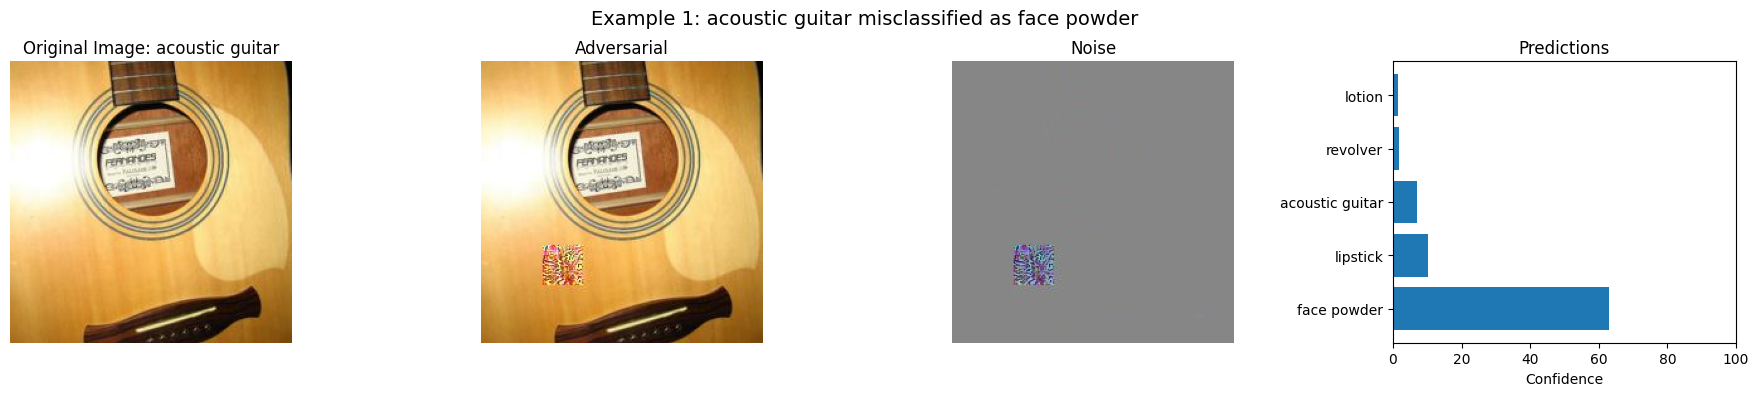

Original class: acoustic guitar (ImageNet index: 402)
Misclassified as: face powder (ImageNet index: 551)
Top 5 predictions for adversarial image:
  1. face powder: 62.91%
  2. lipstick: 10.18%
  3. acoustic guitar: 7.13%
  4. revolver: 1.80%
  5. lotion: 1.60%




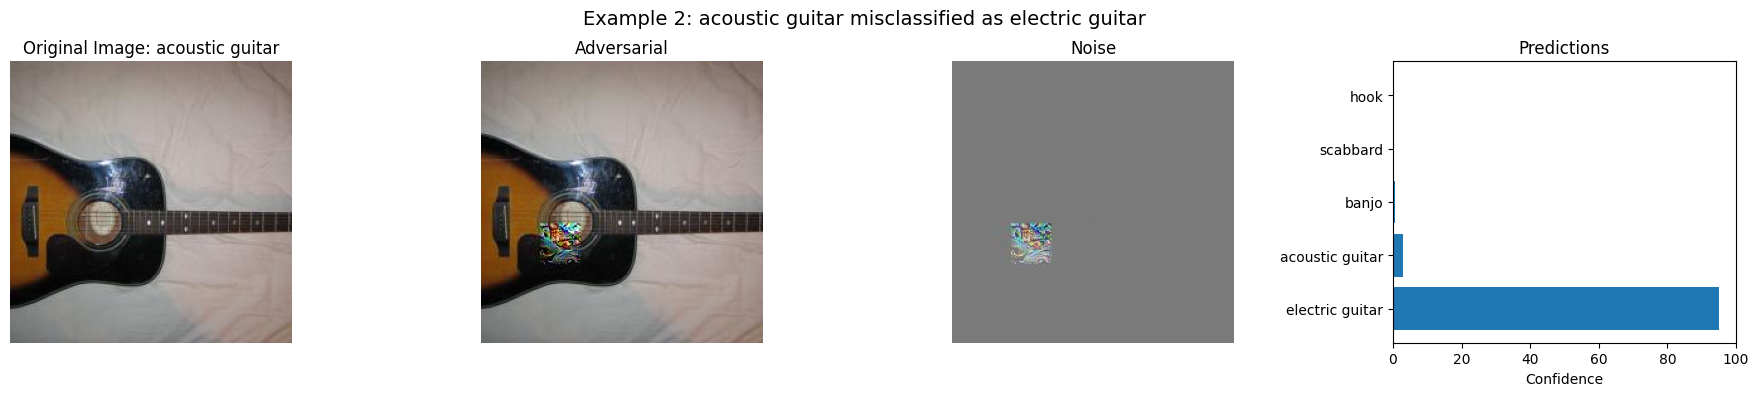

Original class: acoustic guitar (ImageNet index: 402)
Misclassified as: electric guitar (ImageNet index: 546)
Top 5 predictions for adversarial image:
  1. electric guitar: 95.03%
  2. acoustic guitar: 2.95%
  3. banjo: 0.56%
  4. scabbard: 0.10%
  5. hook: 0.09%




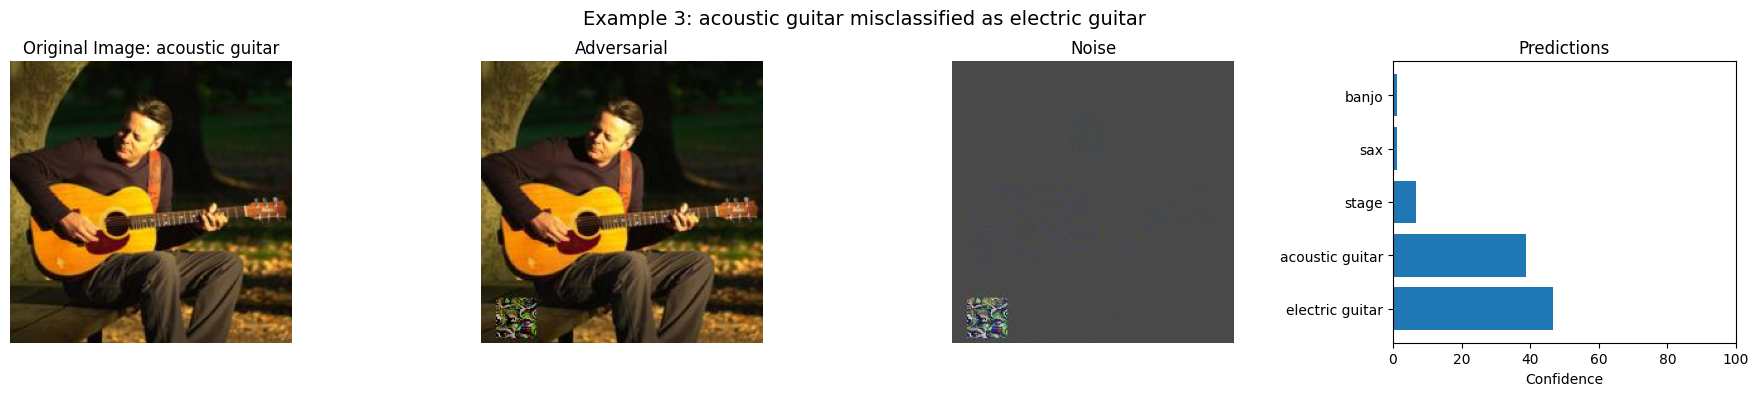

Original class: acoustic guitar (ImageNet index: 402)
Misclassified as: electric guitar (ImageNet index: 546)
Top 5 predictions for adversarial image:
  1. electric guitar: 46.59%
  2. acoustic guitar: 38.68%
  3. stage: 6.84%
  4. sax: 1.16%
  5. banjo: 1.11%




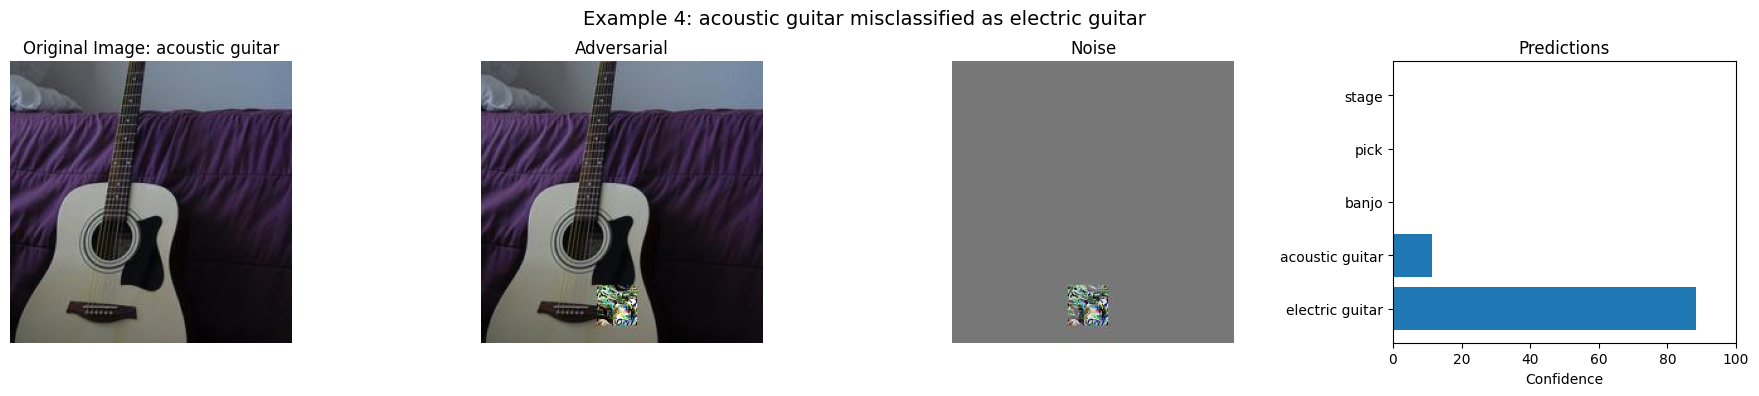

Original class: acoustic guitar (ImageNet index: 402)
Misclassified as: electric guitar (ImageNet index: 546)
Top 5 predictions for adversarial image:
  1. electric guitar: 88.28%
  2. acoustic guitar: 11.42%
  3. banjo: 0.21%
  4. pick: 0.05%
  5. stage: 0.02%




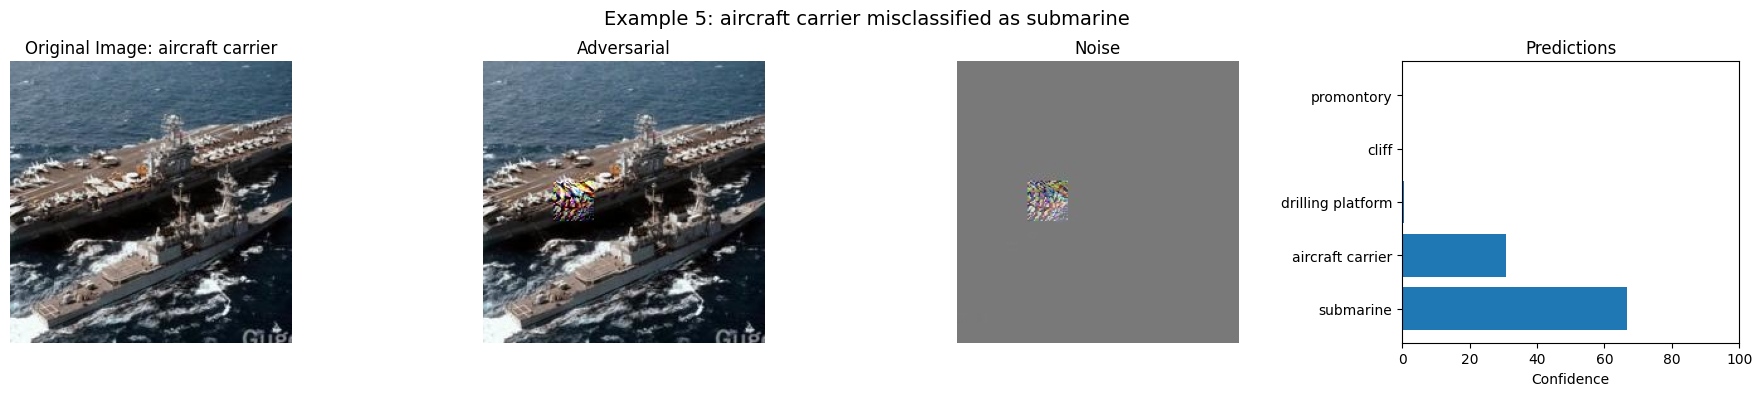

Original class: aircraft carrier (ImageNet index: 403)
Misclassified as: submarine (ImageNet index: 833)
Top 5 predictions for adversarial image:
  1. submarine: 66.65%
  2. aircraft carrier: 30.89%
  3. drilling platform: 0.50%
  4. cliff: 0.26%
  5. promontory: 0.25%




In [24]:
visualize_adversarial_examples(pretrained_model,
                       dataset,
                       adv3i_dataset,
                       idx_to_imagenet,
                       imagenet_class_mapping,
                       n_examples=5)

### Improving patch attack using completely different strategy (LaVAN)

In [29]:
# LaVAN-style localized patch attack (per-image)
import random

def create_adversarial_example_patch_lavan_final(
    model, image, true_label,
    epsilon=0.5,
    alpha=0.1,
    num_steps=40,
    patch_size=32,
    loc_restarts=5
):

    device = image.device
    model.eval()

    # build normalization tensors
    mean_t = torch.tensor(mean_norms, device=device, dtype=image.dtype).view(3,1,1)
    std_t  = torch.tensor(std_norms,  device=device, dtype=image.dtype).view(3,1,1)

    orig_raw = image * std_t + mean_t
    H, W = image.shape[1:]
    best_adv = None
    best_loss = -float('inf')

    for _ in range(loc_restarts):
        top  = random.randint(0, H - patch_size)
        left = random.randint(0, W - patch_size)

        # δ only inside the patch region
        delta = torch.zeros((3, patch_size, patch_size), device=device, requires_grad=True)
        optimizer = torch.optim.Adam([delta], lr=alpha)

        for _ in range(num_steps):
            adv_raw = orig_raw.clone()
            adv_raw[:, top:top+patch_size, left:left+patch_size] += delta
            adv_raw = torch.clamp(adv_raw, 0.0, 1.0)
            adv_norm = (adv_raw - mean_t) / std_t

            logits = model(adv_norm.unsqueeze(0))
            loss   = F.cross_entropy(logits, torch.tensor([true_label], device=device))

            # maximize loss → minimize -loss
            optimizer.zero_grad()
            (-loss).backward()
            optimizer.step()

            # clip δ to L∞ ball
            with torch.no_grad():
                delta.clamp_(-epsilon, epsilon)

        # evaluate final CE loss
        with torch.no_grad():
            adv_raw = orig_raw.clone()
            adv_raw[:, top:top+patch_size, left:left+patch_size] += delta
            adv_raw = torch.clamp(adv_raw, 0.0, 1.0)
            adv_norm = (adv_raw - mean_t)/std_t
            ce = F.cross_entropy(model(adv_norm.unsqueeze(0)),
                                 torch.tensor([true_label], device=device))

            if ce.item() > best_loss:
                best_loss = ce.item()
                best_adv  = adv_norm.squeeze(0).detach()

    return best_adv


In [33]:
# generate “AdversarialTestSet3_LaVAN_Final” (500 images)
eps, alpha, steps, restarts = 0.5,0.5/80, 80, 5

adv3l_path = "./AdversarialTestSet3_LaVAN_Final"
os.makedirs(adv3l_path, exist_ok=True)
for cls in os.listdir(dataset_path):
    if os.path.isdir(os.path.join(dataset_path, cls)):
        os.makedirs(os.path.join(adv3l_path, cls), exist_ok=True)

loader = DataLoader(dataset, batch_size=1, shuffle=False)
for i, (img, lbl) in enumerate(loader):
    if i >= 500: break
    img, lbl = img.squeeze(0).to(device), lbl.to(device)
    ds_idx   = lbl.item()
    if ds_idx not in idx_to_imagenet: continue
    true_idx = idx_to_imagenet[ds_idx]

    adv3l = create_adversarial_example_patch_lavan_final(
        pretrained_model, img, true_idx,
        epsilon=eps,
        alpha=alpha,
        num_steps=steps,
        patch_size=32,
        loc_restarts=restarts
    )

    # save adv image
    raw = torch.clamp(adv3l * std + mean, 0.0, 1.0)
    raw_img = raw
    if raw_img.dim() == 4:
        raw_img = raw_img.squeeze(0)  # now (3, H, W)

    arr = (raw_img.cpu().numpy().transpose(1, 2, 0) * 255).round().astype(np.uint8)

    pil = Image.fromarray(arr)

    folder = os.path.basename(os.path.dirname(dataset.samples[i][0]))
    name   = os.path.basename(dataset.samples[i][0])
    pil.save(os.path.join(adv3l_path, folder, name))

print("Done generating Adversarial Test Set 3 LaVAN_Final.")


Done generating Adversarial Test Set 3 LaVAN_Final.


In [34]:
# evaluate “AdversarialTestSet3_LaVAN_Final”
adv3l_ds     = datasets.ImageFolder(root=adv3l_path, transform=plain_transforms)
adv3l_loader = DataLoader(adv3l_ds, batch_size=32, shuffle=False)

adv3l_top1 = adv3l_top5 = tot = 0
with torch.no_grad():
    for imgs, lbls in adv3l_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        outs = pretrained_model(imgs)
        _, p1 = outs.topk(1, dim=1)
        _, p5 = outs.topk(5, dim=1)
        for j, lab in enumerate(lbls):
            ds_idx = lab.item()
            if ds_idx not in idx_to_imagenet: continue
            im_idx = idx_to_imagenet[ds_idx]
            tot += 1
            if p1[j,0].item() == im_idx:   adv3l_top1 += 1
            if im_idx in p5[j].tolist():  adv3l_top5 += 1

adv3l_top1_acc = 100 * adv3l_top1 / tot
adv3l_top5_acc = 100 * adv3l_top5 / tot

drop1 = 100 * (76.00 - adv3l_top1_acc) / 76.00
drop5 = 100 * (94.20 - adv3l_top5_acc) / 94.20

print(f"Patch 32×32 Saliency MIM (best) Top-1 Accuracy: {adv3l_top1_acc:.2f}%")
print(f"Patch 32×32 Saliency MIM (best) Top-5 Accuracy: {adv3l_top5_acc:.2f}%")
print(f"Drop in Top-1: {drop1:.2f}%, Drop in Top-5: {drop5:.2f}%")

Patch 32×32 Saliency MIM (best) Top-1 Accuracy: 18.00%
Patch 32×32 Saliency MIM (best) Top-5 Accuracy: 64.00%
Drop in Top-1: 76.32%, Drop in Top-5: 32.06%


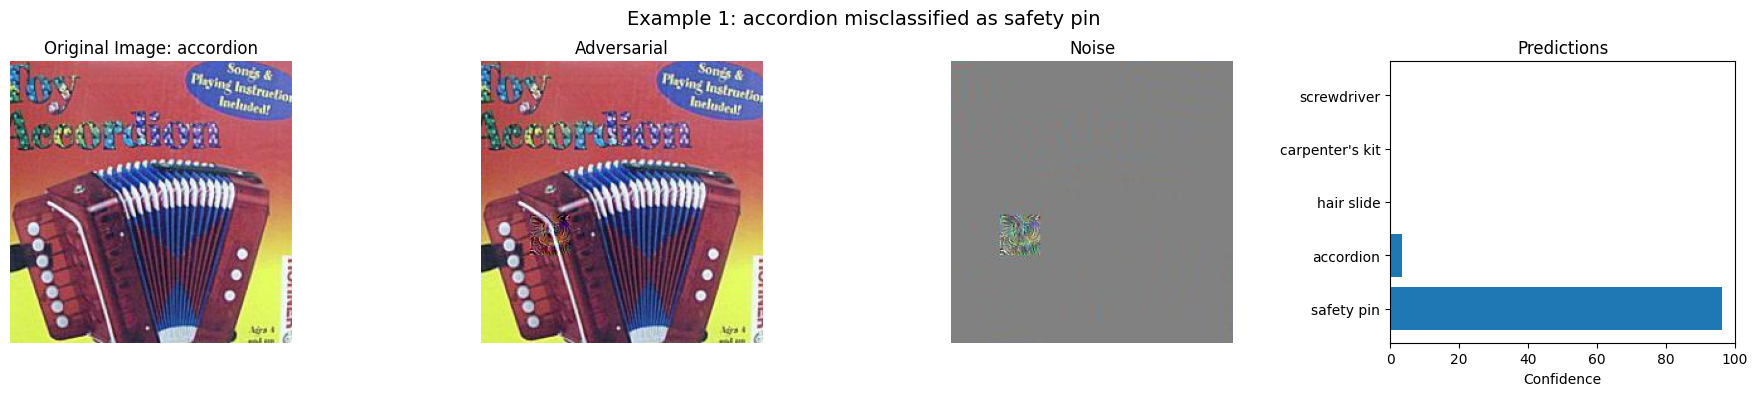

Original class: accordion (ImageNet index: 401)
Misclassified as: safety pin (ImageNet index: 772)
Top 5 predictions for adversarial image:
  1. safety pin: 96.26%
  2. accordion: 3.52%
  3. hair slide: 0.17%
  4. carpenter's kit: 0.02%
  5. screwdriver: 0.01%




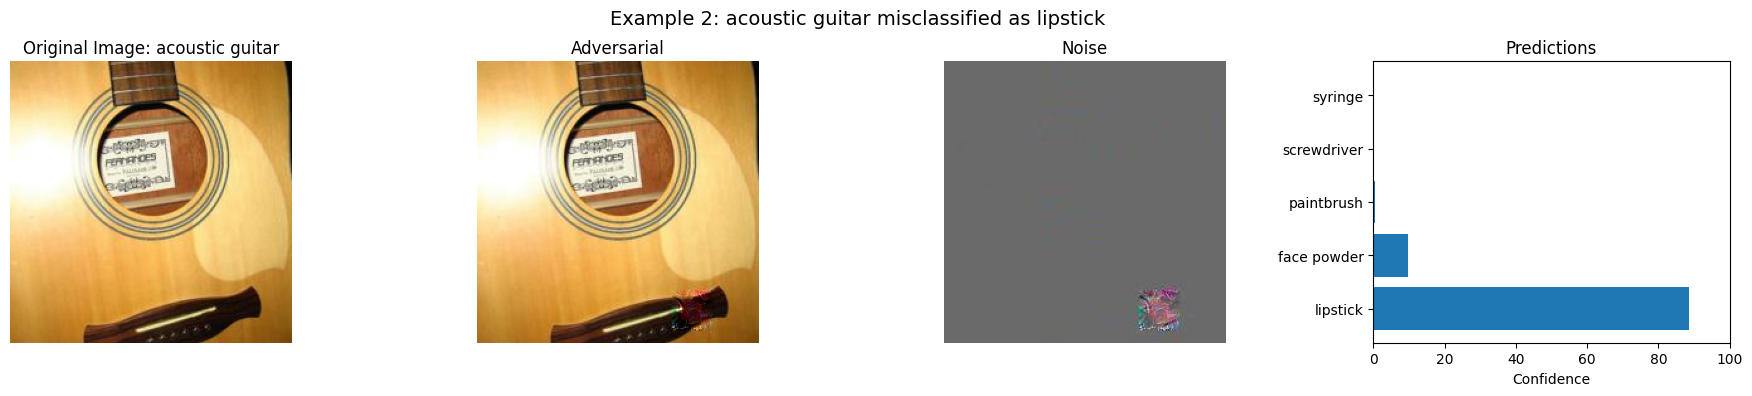

Original class: acoustic guitar (ImageNet index: 402)
Misclassified as: lipstick (ImageNet index: 629)
Top 5 predictions for adversarial image:
  1. lipstick: 88.54%
  2. face powder: 9.62%
  3. paintbrush: 0.56%
  4. screwdriver: 0.29%
  5. syringe: 0.12%




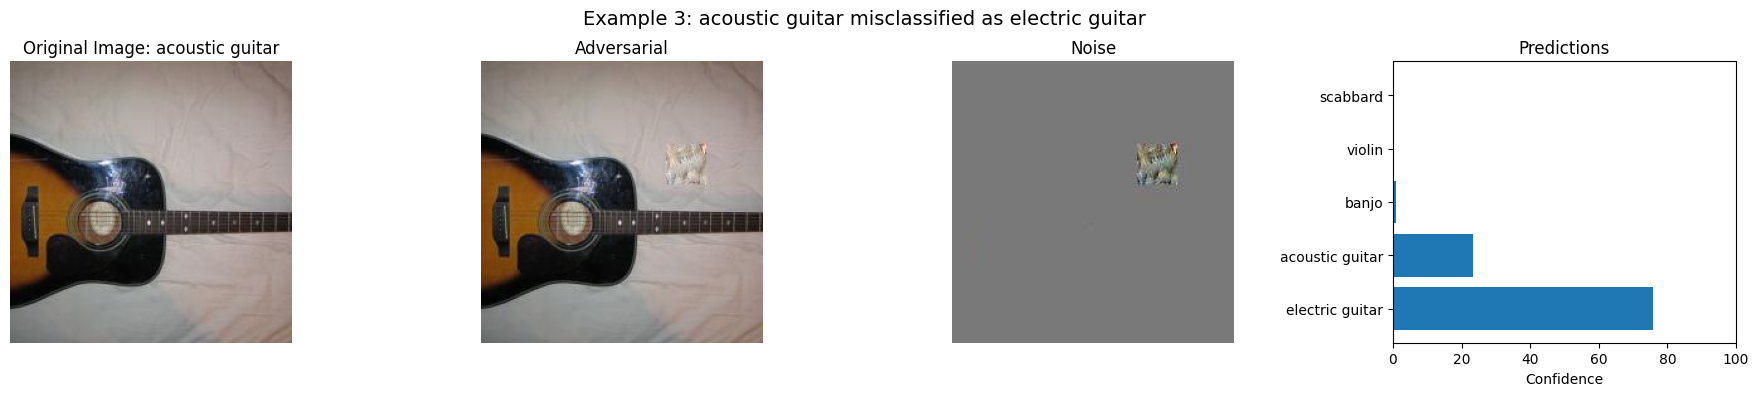

Original class: acoustic guitar (ImageNet index: 402)
Misclassified as: electric guitar (ImageNet index: 546)
Top 5 predictions for adversarial image:
  1. electric guitar: 75.88%
  2. acoustic guitar: 23.28%
  3. banjo: 0.75%
  4. violin: 0.01%
  5. scabbard: 0.01%




In [35]:
visualize_adversarial_examples(pretrained_model,
                       dataset,
                       adv3l_ds,
                       idx_to_imagenet,
                       imagenet_class_mapping,
                       n_examples=3)

Task 5: Transferability of Attacks using EfficientNet-B0

In [36]:
from torchvision.models import EfficientNet_B0_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = EfficientNet_B0_Weights.IMAGENET1K_V1
model_effnet = models.efficientnet_b0(weights=weights).to(device)
model_effnet.eval()

plain_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms),
])

paths = {
    "test": dataset_path,
    "adv1": "./AdversarialTestSet1",
    "adv2": "./AdversarialTestSet2",
    "adv2i": "./AdversarialTestSet2_Improved",
    "adv3": "./AdversarialTestSet3",
    "adv3i": "./AdversarialTestSet3_Improved",
    "adv3l": "./AdversarialTestSet3_LaVAN_Final"
}

results_effnet = {}
for key, path in paths.items():
    ds     = datasets.ImageFolder(root=path, transform=plain_transforms)
    loader = DataLoader(ds, batch_size=32, shuffle=False)
    top1 = top5 = total = 0
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            outs       = model_effnet(imgs)
            _, p1      = outs.topk(1, dim=1)
            _, p5      = outs.topk(5, dim=1)
            for i, lab in enumerate(lbls):
                ds_idx = lab.item()
                if ds_idx not in idx_to_imagenet:
                    continue
                im_idx = idx_to_imagenet[ds_idx]
                total += 1
                if p1[i,0].item() == im_idx:    top1 += 1
                if im_idx in p5[i].tolist():    top5 += 1
    results_effnet[key] = (100 * top1 / total, 100 * top5 / total)

test_top1_acc_effnet,   test_top5_acc_effnet   = results_effnet["test"]
adv1_top1_acc_effnet,   adv1_top5_acc_effnet   = results_effnet["adv1"]
adv2_top1_acc_effnet,   adv2_top5_acc_effnet   = results_effnet["adv2"]
adv2i_top1_acc_effnet,  adv2i_top5_acc_effnet  = results_effnet["adv2i"]
adv3_top1_acc_effnet,   adv3_top5_acc_effnet   = results_effnet["adv3"]
adv3i_top1_acc_effnet,  adv3i_top5_acc_effnet  = results_effnet["adv3i"]
adv3l_top1_acc_effnet,  adv3l_top5_acc_effnet  = results_effnet["adv3l"]


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 121MB/s] 


# Summary of Results

In [40]:

import pandas as pd

tasks = [
    "Task 1: TestSet (Baseline)",
    "Task 2: AdversarialTestSet1 (FGSM)",
    "Task 3: AdversarialTestSet2 (PGD)",
    "Task 3: AdversarialTestSet2_Improved (MIM)",
    "Task 4: AdversarialTestSet3 (Patch MIM)",
    "Task 4: AdvancedTestSet3_Improved (Patch Saliency MIM)",
    "Task 4: AdvancedTestSet3_LaVAN_Final (LaVAN)"
]

# Hard-coded ResNet34 accuracies
resnet_vals = [
    (76.00, 94.20),
    (6.20, 33.20),
    (1.20, 30.80),
    (0.00, 11.80),
    (65.80, 88.20),
    (26.40, 74.60),
    (18.00, 64.00)
]

effnet_vals = [
    (test_top1_acc_effnet,   test_top5_acc_effnet),
    (adv1_top1_acc_effnet,   adv1_top5_acc_effnet),
    (adv2_top1_acc_effnet,   adv2_top5_acc_effnet),
    (adv2i_top1_acc_effnet,  adv2i_top5_acc_effnet),
    (adv3_top1_acc_effnet,   adv3_top5_acc_effnet),
    (adv3i_top1_acc_effnet,  adv3i_top5_acc_effnet),
    (adv3l_top1_acc_effnet,  adv3l_top5_acc_effnet)
]

rows = []
for ds, (r1, r5), (e1, e5) in zip(tasks, resnet_vals, effnet_vals):
    rows.append({"DataSet": ds, "Model": "ResNet34",        "Top1 (%)": r1,  "Top5 (%)": r5})
    rows.append({"DataSet": ds, "Model": "EfficientNet-B0", "Top1 (%)": e1,  "Top5 (%)": e5})

df = pd.DataFrame(rows)
display(df)


DataSet            Model  \
0                          Task 1: TestSet (Baseline)         ResNet34   
1                          Task 1: TestSet (Baseline)  EfficientNet-B0   
2                  Task 2: AdversarialTestSet1 (FGSM)         ResNet34   
3                  Task 2: AdversarialTestSet1 (FGSM)  EfficientNet-B0   
4                   Task 3: AdversarialTestSet2 (PGD)         ResNet34   
5                   Task 3: AdversarialTestSet2 (PGD)  EfficientNet-B0   
6          Task 3: AdversarialTestSet2_Improved (MIM)         ResNet34   
7          Task 3: AdversarialTestSet2_Improved (MIM)  EfficientNet-B0   
8             Task 4: AdversarialTestSet3 (Patch MIM)         ResNet34   
9             Task 4: AdversarialTestSet3 (Patch MIM)  EfficientNet-B0   
10  Task 4: AdvancedTestSet3_Improved (Patch Salie...         ResNet34   
11  Task 4: AdvancedTestSet3_Improved (Patch Salie...  EfficientNet-B0   
12       Task 4: AdvancedTestSet3_LaVAN_Final (LaVAN)         ResNet34   
13       Task 4: AdvancedTestSet3_LaVAN_Final (LaVAN)  EfficientNet-B0   

    Top1 (%)  Top5 (%)  
0       76.0      94.2  
1       79.8      97.0  
2        6.2      33.2  
3       63.0      89.2  
4        1.2      30.8  
5       68.0      93.4  
6        0.0      11.8  
7       64.2      92.0  
8       65.8      88.2  
9       76.8      96.0  
10      26.4      74.6  
11      75.0      94.4  
12      18.0      64.0  
13      73.4      94.4